## Augmentation procedure on the simple AE

In [3]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

In [4]:
class MyFirstAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(MyFirstAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x):
        """
        Take a mini-batch as an input, encode it to the latent space and decode back to the original space
        x_out = decoder(encoder(x))
        :param x: torch.tensor, (MB, x_dim)
        :return: torch.tensor, (MB, x_dim)
        """
        return self.decoder(self.encoder(x))

In [5]:
encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),            
            nn.LeakyReLU(0.1),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),          
            nn.LeakyReLU(0.1),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(64, 4, 3, stride=1, padding=1)
        )

decoder = nn.Sequential(
            nn.Conv2d(4, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 4, stride=2, padding=1),
            nn.Sigmoid()
        )

In [6]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transform)

In [7]:
device = 'cuda:0'

net = MyFirstAE(encoder, decoder)  
criterion = nn.MSELoss().to('cuda:0')
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, gamma=0.95)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True)

In [ ]:
def train(epochs, net, criterion, optimizer, train_loader, scheduler=None, verbose=True, save_dir=None):
    net.to(device)
    for epoch in range(1, epochs+1):
        net.train()
        for X, _ in train_loader:
            # Perform one step of minibatch stochastic gradient descent
            
            # >>> your solution here <<<
            #flat = nn.Flatten()
            #X = flat(X)
            
            loss = criterion(net.to('cuda:0')(X.to('cuda:0')), X.to('cuda:0'))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
       
        if scheduler is not None:
            scheduler.step()
        freq = max(epochs//20,1)
        if verbose and epoch%freq==0:
            print('Epoch {}/{} || Loss:  Train {:.4f} '.format(epoch, epochs, loss.item()))

In [ ]:
train(100, net, criterion, optimizer, train_loader, scheduler)

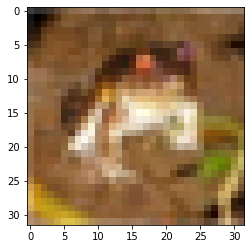

In [18]:
plt.imshow(np.transpose(trainset[0][0], (1, 2, 0)))

In [19]:
torch.save(net.state_dict(), './weights/model.pt')

## Experiments with augmentations

In [22]:
autoencoder = MyFirstAE(encoder, decoder)
autoencoder.load_state_dict(torch.load('./weights/model.pt', map_location='cuda:0'))
autoencoder.to('cuda:0')

MyFirstAE(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.1)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.1)
    (6): Conv2d(64, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (decoder): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(16, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): Sigmoid()
  )
)

In [23]:
autoencoder.decoder.eval()

Sequential(
  (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): ConvTranspose2d(16, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (7): Sigmoid()
)

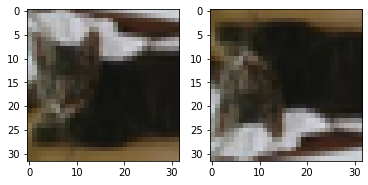

In [25]:
index = 9
flip = lambda x: x.numpy()[:, ::-1].copy()

img = trainset[index][0]

fig, ax = plt.subplots(ncols=2)
ax[0].imshow(np.transpose(img, (1, 2, 0)))
ax[1].imshow(np.transpose(flip(img), (1, 2, 0)));

In [26]:
img_origin = torch.Tensor(img[np.newaxis, :]).to('cuda:0') 
img_flip = torch.Tensor(flip(img)[np.newaxis, :]).to('cuda:0')
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=5e-3)

In [7]:
reconstruct_origin = img_origin.cpu().detach().numpy()[0]
print(reconstruct_origin.shape)

(3, 32, 32)

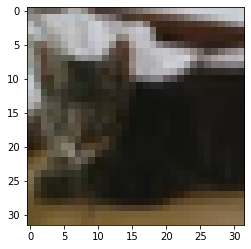

In [8]:
plt.imshow(np.transpose(reconstruct_origin, (1, 2, 0)))

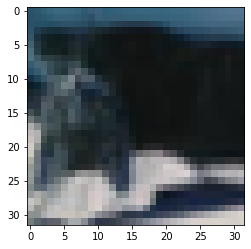

In [43]:
plt.imshow(np.transpose(reconstruct_flip, (1, 2, 0)))

In [27]:
def augmentation(X):
    aug_idx = np.random.randint(5)
    if aug_idx == 0:
        return torch.flip(X, (2,))
    if aug_idx == 1:
        return torch.flip(X, (3,))
    if aug_idx == 2:
        return torch.flip(X, (3, 2))
    if aug_idx == 3:
        return torch.flip(X, (1,))
    if aug_idx == 4:
        return torch.flip(X, (1, 2))

In [29]:
distances = []
autoencoder.decoder.eval()
autoencoder.to('cuda:0')

for X_origin, _ in train_loader:   # надо указать trainloader своего AE
    X_aug = augmentation(X_origin)
    X_origin, X_aug = X_origin.to('cuda:0'), X_aug.to('cuda:0')
    dist = []
    for _ in range(7): # в зависимости от LR
        points_origin = autoencoder.encoder(X_origin)
        points_aug = autoencoder.encoder(X_aug)

        dist.append(((points_origin - points_aug) ** 2).sum().item() / 32)    # делить на батч сайз

        out_origin, out_aug = autoencoder.decoder(points_origin), autoencoder.decoder(points_aug)

        loss = F.mse_loss(X_origin, out_aug) + F.mse_loss(X_aug, out_origin)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    distances.append(dist)

In [30]:
distances = np.array(distances)

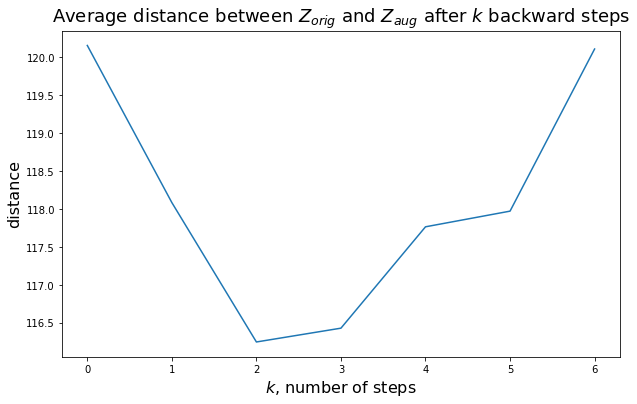

In [31]:
plt.figure(figsize=(10,6))
plt.title('Average distance between $Z_{orig}$ and $Z_{aug}$ after $k$ backward steps', fontsize=18)
plt.plot(distances.mean(axis=0));
plt.xlabel('$k$, number of steps', fontsize=16)
plt.ylabel('distance', fontsize=16);

In [55]:
X = []
labels = []
for x, y in trainloader:
    x = x.to('cuda:0')
    points = autoencoder.encoder(x)
    X.append(points.cpu().detach().numpy())
    labels.extend(y)
X = np.vstack(X).reshape(50000, -1)

In [62]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mutual_info_score

In [63]:
kmeans = KMeans(n_clusters=10)

In [64]:
kmeans.fit(XX, np.array(labels))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [65]:
predictions = kmeans.predict(XX)
print('silhouette_score:', silhouette_score(XX, predictions))
print('mutual_info_score:', mutual_info_score(labels, predictions))

silhouette_score: 0.15832725
mutual_info_score: 0.07039428979757172


In [67]:
old_autoencoder = MyFirstAE(encoder, decoder)
old_autoencoder.load_state_dict(torch.load('./weights/model.pt', map_location='cuda:0'))
old_autoencoder.to('cuda:0')

MyFirstAE(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.1)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.1)
    (6): Conv2d(64, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (decoder): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(16, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): Sigmoid()
  )
)

In [68]:
old_autoencoder.decoder.eval()

Sequential(
  (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): ConvTranspose2d(16, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (7): Sigmoid()
)

In [69]:
old_X = []
for x, _ in trainloader:
    x = x.to('cuda:0')
    points = old_autoencoder.encoder(x)
    old_X.append(points.cpu().detach().numpy())
    
old_XX = np.vstack(old_X).reshape(50000, -1)

In [70]:
kmeans_old = KMeans(n_clusters=10)
kmeans_old.fit(old_XX, np.array(labels))

old_predictions = kmeans_old.predict(old_XX)
print('silhouette_score:', silhouette_score(old_XX, old_predictions))
print('mutual_info_score:', mutual_info_score(labels, old_predictions))

silhouette_score: 0.05186945
mutual_info_score: 0.0006546976044007821


In [74]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [72]:
knn = KNeighborsClassifier()

In [73]:
knn.fit(XX, labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [75]:
print('Accuracy:', accuracy_score(labels, knn.predict(XX)))

Accuracy: 0.48408


In [76]:
knn_old = KNeighborsClassifier()
knn_old.fit(old_XX, labels)
print('Accuracy:', accuracy_score(labels, knn_old.predict(old_XX)))

Accuracy: 0.35976
